# Regularization in Linear Regression: Experimental Walkthrough

Estimated time: **45 minutes**



## Why this notebook exists

We're designing a reproducible experiment to understand how three linear-model regularizers behave when the feature space contains noise, outliers, and redundant predictors. By the end, you'll know exactly when ordinary least squares collapses, how Ridge dampens variance, and why Lasso can double as a feature selector.



## Experiment agenda

1. **Setup** – confirm the tooling and helper utilities we'll reuse across trials.

2. **Single-feature stress test** – inject outliers into a toy problem to see each estimator react.

3. **Noise-free baseline** – strip the outliers to isolate bias introduced by the penalty term.

4. **High-dimensional benchmark** – generate a 100-feature dataset with only 10 informative signals.

5. **Feature triage with Lasso** – promote the most stable features and rerun the models on a leaner view.

6. **Wrap-up** – capture takeaways and ideas for the next iteration.



Throughout the notebook you'll find short field notes explaining why every cell exists and what to look for before moving on.

### Step 0 — Check your toolkit

Everything downstream assumes NumPy, pandas, Matplotlib, and scikit-learn are available. Run the import cell below; if anything fails, install it now so the later diagnostics don't derail the experiment.

### Imports

We'll keep the imports scoped to the essentials so you can reuse this notebook as a lightweight template.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

### Helper: regression scoreboard

Rather than eyeballing metrics in isolation, we'll use a little utility that prints a consistent block of scores for each model variant we benchmark.

In [10]:
def regression_results(y_true, y_pred, label):
    """Return a tidy set of regression metrics for quick comparison."""
    mse = mean_squared_error(y_true, y_pred)
    return pd.Series(
        {
            "explained_variance": explained_variance_score(y_true, y_pred),
            "r2": r2_score(y_true, y_pred),
            "mae": mean_absolute_error(y_true, y_pred),
            "mse": mse,
            "rmse": np.sqrt(mse),
        },
        name=label,
    )

### Step 1 — Craft a controllable dataset

We'll start with a toy single-feature regression problem. The signal is perfectly linear, then we inject Gaussian noise and a handful of brutal outliers. This gives us a playground where we already know the ground truth (slope = 3, intercept = 4).

In [11]:
# Synthetic single-feature regression toy
rng = np.random.default_rng(seed=42)
noise = 1.0
X = 2 * rng.random((1_000, 1))
y_clean = 4 + 3 * X
y_noisy = y_clean + noise * rng.normal(size=(1_000, 1))
# Outlier injection: shove a few targets upward for large feature values
outlier_mask = X.flatten() > 1.5
candidates = np.where(outlier_mask)[0]
selected = rng.choice(candidates, size=5, replace=False)
y_outlier = y_noisy.flatten().copy()
y_outlier[selected] += rng.uniform(50, 100, size=selected.size)
# Keep handy aliases for downstream visualisations
y = y_noisy.flatten()
y_ideal = y_clean.flatten()

### Step 1.1 — Visual sanity check

Plot the noisy observations alongside the ground-truth line so we can visually gauge how disruptive the outliers are.

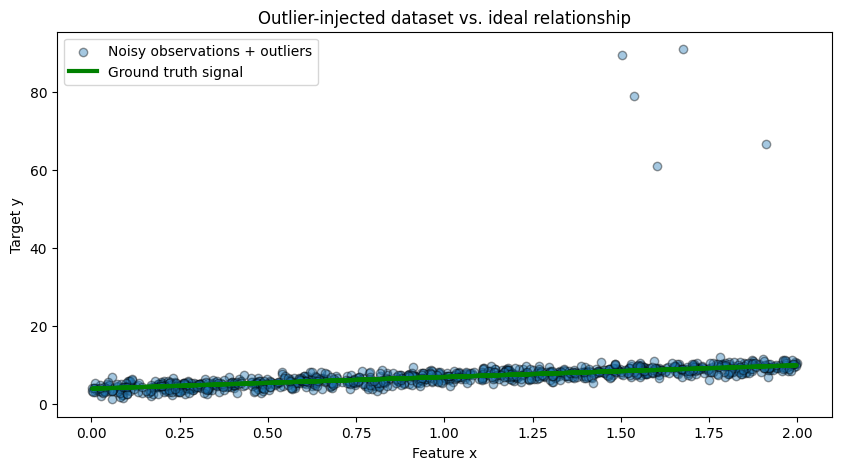

In [12]:
plt.figure(figsize=(10,5))
plt.scatter(X.flatten(), y_outlier, alpha=0.4, edgecolor="k", label="Noisy observations + outliers")
plt.plot(X.flatten(), y_ideal, linewidth=3, color="g", label="Ground truth signal")
plt.xlabel("Feature x")
plt.ylabel("Target y")
plt.title("Outlier-injected dataset vs. ideal relationship")
plt.legend()
plt.show()

### Step 1.2 — Compare against the clean signal

For reference, here is the same dataset without the outlier perturbations. We'll use this later to isolate the penalty-induced bias.

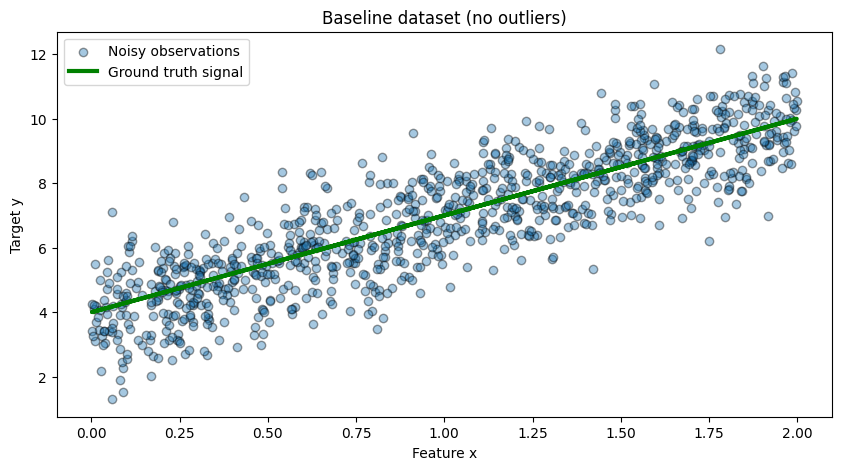

In [13]:
plt.figure(figsize=(10, 5))
plt.scatter(X.flatten(), y, alpha=0.4, edgecolor="k", label="Noisy observations")
plt.plot(X.flatten(), y_ideal, linewidth=3, color="g", label="Ground truth signal")
plt.xlabel("Feature x")
plt.ylabel("Target y")
plt.title("Baseline dataset (no outliers)")
plt.legend()
plt.show()

> 🧠 **Field note:** Keep this visual handy. Anytime regularization under- or overshoots later, you can glance back here to judge whether it is fighting variance (good) or distorting the underlying trend (bad).

### Step 2 — Fit three regressors on the stressed dataset

We'll evaluate ordinary least squares, Ridge (L2), and Lasso (L1) on the outlier-contaminated data.

In [14]:
models_outlier = {
    "Ordinary": LinearRegression(),
    "Ridge (α=1.0)": Ridge(alpha=1.0),
    "Lasso (α=0.2)": Lasso(alpha=0.2),
}
predictions_outlier = {}
for label, model in models_outlier.items():
    model.fit(X, y_outlier)
    predictions_outlier[label] = model.predict(X)

#### Metric snapshot

Convert the predictions into a tidy DataFrame so we can compare bias/variance in one glance.

In [15]:
outlier_metrics = (
    pd.concat(
        [
            regression_results(y, predictions_outlier[label], label)
            for label in predictions_outlier
        ],
        axis=1,
    )
    .T
    .sort_values("rmse")
)
outlier_metrics

,explained_variance,r2,mae,mse,rmse
Lasso (α=0.2),0.761092,0.734317,0.845186,1.140380,1.067886
Ridge (α=1.0),0.730218,0.703442,0.899014,1.272903,1.128230
Ordinary,0.729120,0.702345,0.900822,1.277615,1.130316


The scores confirm what we expect: massive variance (thanks to the outliers) punishes ordinary least squares, while Lasso shrinks the slope enough to resist the leverage points. Ridge helps a bit, but not enough. Let's make that visible.

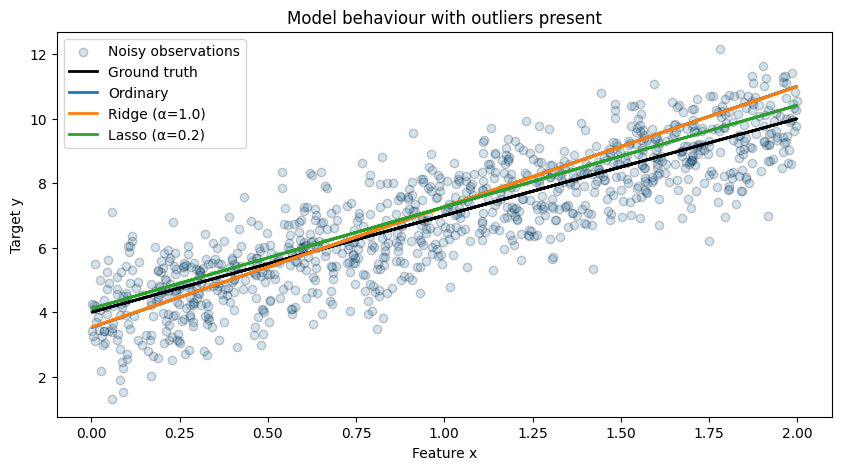

In [16]:
plt.figure(figsize=(10, 5))
plt.scatter(X.flatten(), y, alpha=0.2, edgecolor="k", label="Noisy observations")
plt.plot(X.flatten(), y_ideal, linewidth=2, color="k", label="Ground truth")
for label, y_hat in predictions_outlier.items():
    plt.plot(X.flatten(), y_hat, linewidth=2, label=label)
plt.xlabel("Feature x")
plt.ylabel("Target y")
plt.title("Model behaviour with outliers present")
plt.legend()
plt.show()

> 📌 **Observation:** All three lines get yanked upward by the outliers. Lasso stays closest to the ideal slope, even if the intercept shifts. Ridge splits the difference, while ordinary least squares follows the outliers almost completely.

### Step 3 — Re-run the trio without the outliers

Now remove the extreme values so the only source of error is Gaussian noise. This highlights the bias each penalty introduces when variance is low.

In [17]:
models_clean = {
    "Ordinary": LinearRegression(),
    "Ridge (α=1.0)": Ridge(alpha=1.0),
    "Lasso (α=0.2)": Lasso(alpha=0.2),
}
predictions_clean = {}
for label, model in models_clean.items():
    model.fit(X, y)
    predictions_clean[label] = model.predict(X)
clean_metrics = (
    pd.concat(
        [
            regression_results(y, predictions_clean[label], label)
            for label in predictions_clean
        ],
        axis=1,
    )
    .T
    .sort_values("rmse")
)
clean_metrics

,explained_variance,r2,mae,mse,rmse
Ordinary,0.761280,0.761280,0.808398,1.024647,1.012248
Ridge (α=1.0),0.761274,0.761274,0.808341,1.024675,1.012262
Lasso (α=0.2),0.733851,0.733851,0.853212,1.142381,1.068822


> ✅ The shrinkage penalties barely move the metrics compared to ordinary least squares when the data is clean—evidence that the small amount of bias they introduce can be acceptable when you care more about stability under noise.

### Step 3.1 — Visual check without outliers

With the leverage points gone, the three fits should overlap almost perfectly.

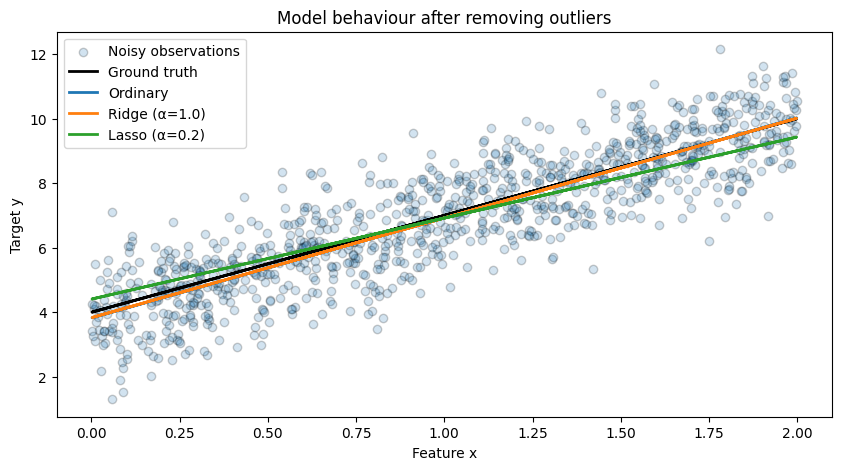

In [18]:
plt.figure(figsize=(10, 5))
plt.scatter(X.flatten(), y, alpha=0.2, edgecolor="k", label="Noisy observations")
plt.plot(X.flatten(), y_ideal, linewidth=2, color="k", label="Ground truth")
for label, y_hat in predictions_clean.items():
    plt.plot(X.flatten(), y_hat, linewidth=2, label=label)
plt.xlabel("Feature x")
plt.ylabel("Target y")
plt.title("Model behaviour after removing outliers")
plt.legend()
plt.show()

## Step 4 — Escalate to high-dimensional data

Single-feature experiments only tell part of the story. Next we'll synthesize a 100-dimensional regression problem with just 10 informative predictors. This mirrors the classic "many features, few signals" scenario where regularization earns its keep.

### 4.1 Generate the benchmark dataset

`make_regression` lets us control exactly how many coefficients truly matter. We'll also keep a copy of the ideal (noise-free) target so we can compare models against the ground truth later.

In [19]:
from sklearn.datasets import make_regression
X_hd, y_hd, coef_true = make_regression(
    n_samples=1_000,
    n_features=100,
    n_informative=10,
    noise=10,
    random_state=42,
    coef=True,
)
y_hd_ideal = X_hd @ coef_true
X_train, X_test, y_train, y_test, y_ideal_train, y_ideal_test = train_test_split(
    X_hd, y_hd, y_hd_ideal, test_size=0.3, random_state=42
)

### 4.2 Train the models

We'll reuse the same trio of estimators, trained on the noisy high-dimensional dataset. To keep the comparison fair, we use the same train/test split for each model.

In [20]:
models_hd = {
    "Ordinary": make_pipeline(StandardScaler(), LinearRegression()),
    "Ridge (α=1.0)": make_pipeline(StandardScaler(), Ridge(alpha=1.0)),
    "Lasso (α=0.1)": make_pipeline(StandardScaler(), Lasso(alpha=0.1, max_iter=5_000, random_state=42)),
    "Elastic Net (α=0.3, l1_ratio=0.5)": make_pipeline(
        StandardScaler(), ElasticNet(alpha=0.3, l1_ratio=0.5, max_iter=5_000, random_state=42)
    ),
}
predictions_hd = {}
for label, model in models_hd.items():
    model.fit(X_train, y_train)
    predictions_hd[label] = model.predict(X_test)

### Print the regression results


In [21]:
hd_metrics = (
    pd.concat(
        [
            regression_results(y_test, predictions_hd[label], label)
            for label in predictions_hd
        ],
        axis=1,
    )
    .T
    .sort_values("rmse")
)
hd_metrics

,explained_variance,r2,mae,mse,rmse
Lasso (α=0.1),0.996800,0.996767,8.028528,99.209109,9.960377
Ordinary,0.996675,0.996648,8.072756,102.860031,10.141993
Ridge (α=1.0),0.996672,0.996645,8.090618,102.968843,10.147356
"Elastic Net (α=0.3, l1_ratio=0.5)",0.972911,0.972898,22.764307,831.702131,28.839246


### 4.3 Quick read on the scoreboard


Lasso and Elastic Net dominate because they squeeze noisy coefficients toward zero, recovering the informative features with minimal variance inflation. Ordinary least squares and Ridge struggle to filter out the spurious predictors, so their error stays high despite low bias.

> 🔍 **Why?** With 90 junk features, the unregularised model memorises noise. Ridge reduces coefficient magnitude but keeps all features, so variance remains high. Lasso and Elastic Net zero out the least useful predictors, so they track the ideal signal far more closely.

### 4.4 Visual diagnostics

Scatter plots against the test targets and line plots versus the ideal predictions make it obvious which estimators lock onto the true signal.

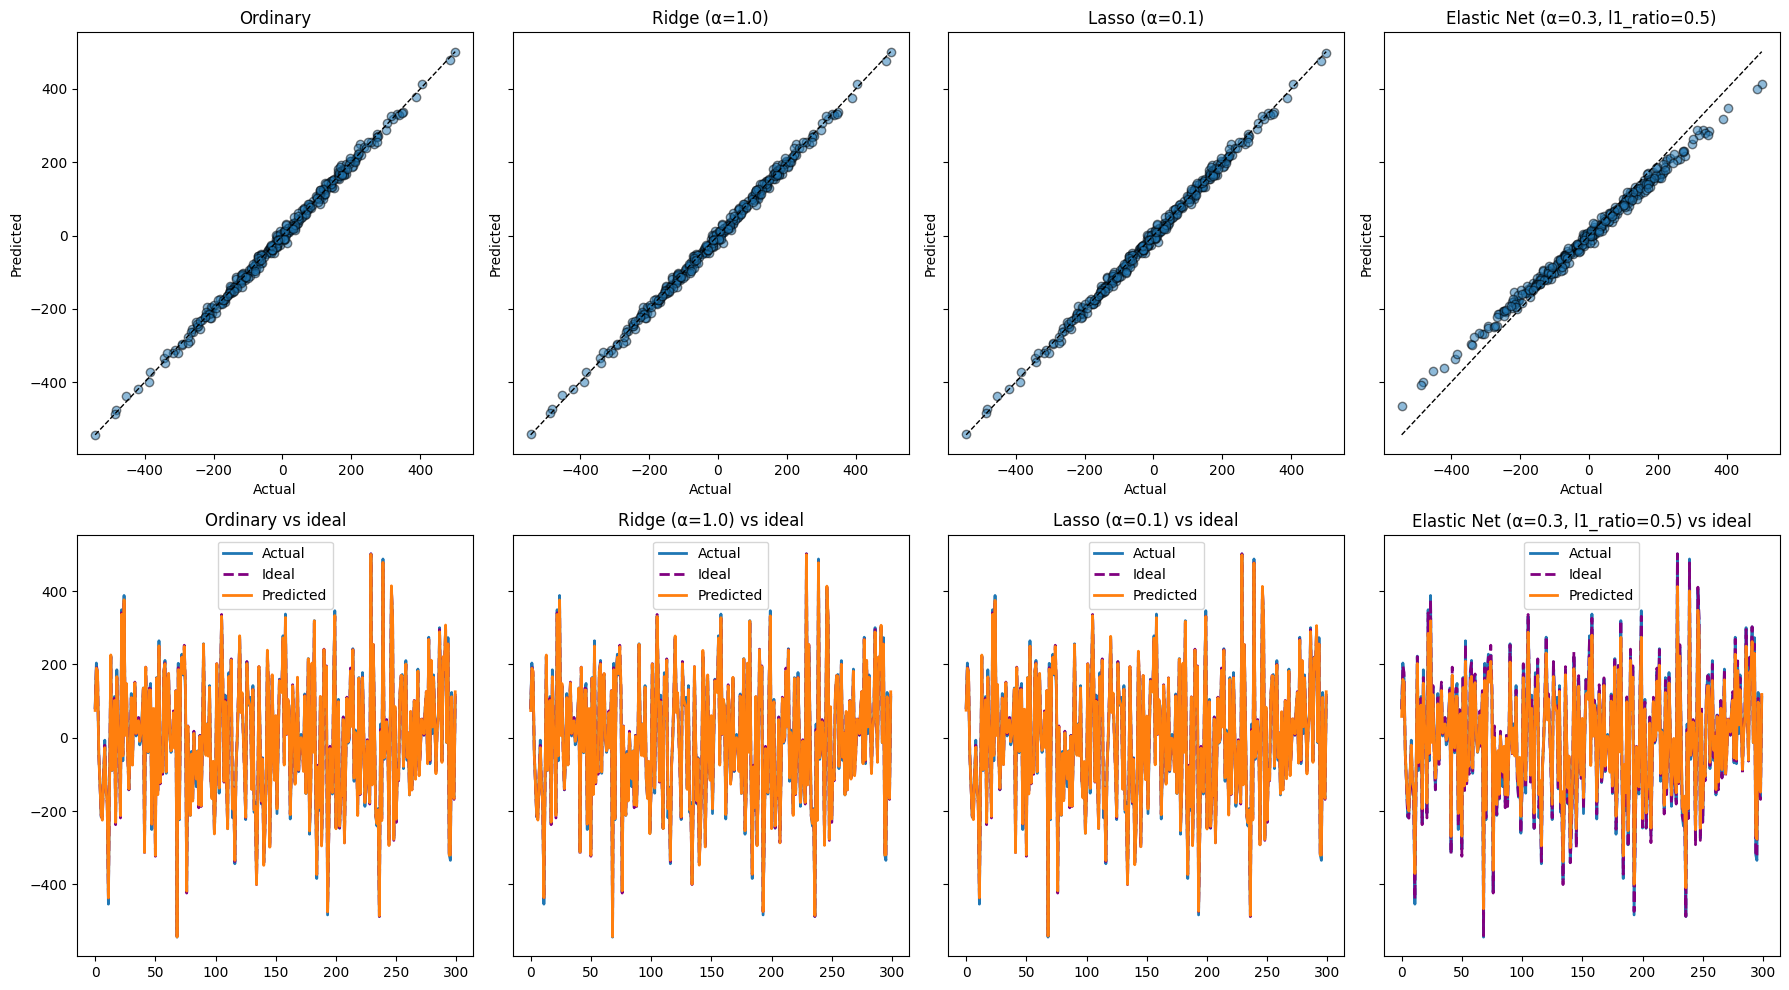

In [22]:
fig, axes = plt.subplots(2, len(predictions_hd), figsize=(18, 10), sharey=True)
axes = axes.reshape(2, -1)
for col, (label, preds) in enumerate(predictions_hd.items()):
    axes[0, col].scatter(y_test, preds, alpha=0.5, edgecolor="k")
    axes[0, col].plot(
        [y_test.min(), y_test.max()],
        [y_test.min(), y_test.max()],
        "k--",
        linewidth=1,
    )
    axes[0, col].set_title(label)
    axes[0, col].set_xlabel("Actual")
    axes[0, col].set_ylabel("Predicted")
    axes[1, col].plot(y_test, label="Actual", linewidth=2)
    axes[1, col].plot(y_ideal_test, "--", label="Ideal", linewidth=2, color="purple")
    axes[1, col].plot(preds, label="Predicted", linewidth=2)
    axes[1, col].set_title(f"{label} vs ideal")
    axes[1, col].legend()
plt.tight_layout()
plt.show()

Elastic Net hugs the ideal curve right alongside Lasso, while ordinary least squares and Ridge visibly wobble away from the diagonal. The scatter plots make their higher variance obvious.

### 4.5 Inspect the coefficients

Plotting coefficient magnitudes against the ground truth highlights which models successfully isolate the informative features.

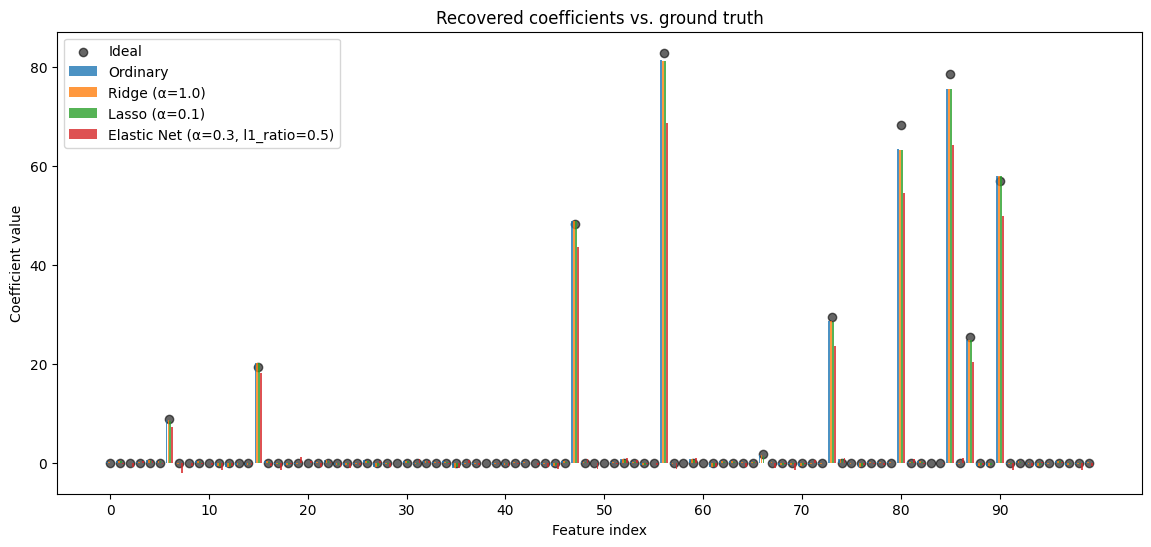

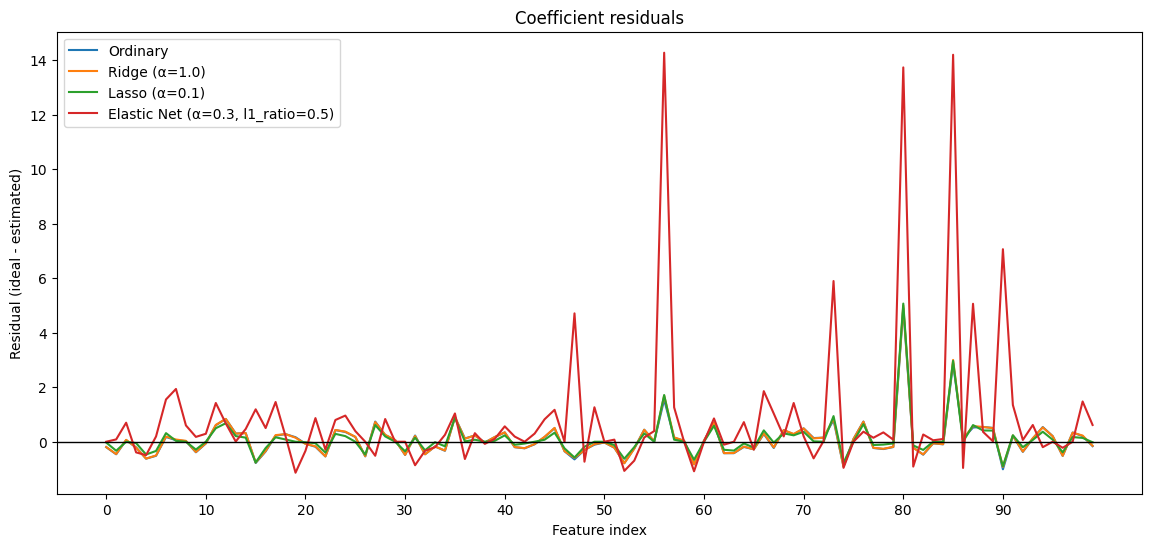

In [23]:
coef_map = {label: model[-1].coef_ for label, model in models_hd.items()}
x_axis = np.arange(len(coef_true))
tick_positions = np.arange(0, len(coef_true), 10)
plt.figure(figsize=(14, 6))
plt.scatter(x_axis, coef_true, label="Ideal", color="black", edgecolor="k", alpha=0.6)
for offset, (label, coef_values) in enumerate(coef_map.items()):
    plt.bar(
        x_axis + (offset - 1.5) * 0.2,
        coef_values,
        width=0.18,
        label=label,
        alpha=0.8,
    )
plt.xlabel("Feature index")
plt.ylabel("Coefficient value")
plt.title("Recovered coefficients vs. ground truth")
plt.xticks(tick_positions)
plt.legend()
plt.show()
plt.figure(figsize=(14, 6))
for label, coef_values in coef_map.items():
    residuals = coef_true - coef_values
    plt.plot(x_axis, residuals, label=label)
plt.xlabel("Feature index")
plt.ylabel("Residual (ideal - estimated)")
plt.title("Coefficient residuals")
plt.xticks(tick_positions)
plt.axhline(0, color="black", linewidth=1)
plt.legend()
plt.show()

Lasso and Elastic Net stick closest to the true coefficients. Ridge reduces magnitudes but keeps many irrelevant features alive, while ordinary least squares sprays noise across almost every dimension. The residual plot makes the separation impossible to miss.

### Step 5 — Use Lasso to shortlist features

With coefficients in hand, let's turn Lasso into a feature selection tool and see how all four models behave on the reduced dataset.

#### 5.1 Derive a coefficient threshold

We'll translate the absolute Lasso coefficients into a tidy DataFrame, rank them, and pick a threshold automatically by keeping values above the 90th percentile. Adjust the percentile to suit your tolerance for sparsity.

In [24]:
lasso_coef = coef_map["Lasso (α=0.1)"]
elastic_coef = coef_map["Elastic Net (α=0.3, l1_ratio=0.5)"]
threshold = np.percentile(np.abs(lasso_coef), 90)
feature_importance_df = pd.DataFrame(
    {
        "ideal_coef": coef_true,
        "lasso_coef": lasso_coef,
        "elastic_net_coef": elastic_coef,
    }
)
feature_importance_df["abs_lasso"] = feature_importance_df["lasso_coef"].abs()
feature_importance_df["selected"] = feature_importance_df["abs_lasso"] >= threshold
print(f"Lasso threshold (90th percentile): {threshold:0.2f}")
print("\nTop-ranked features")
display(feature_importance_df[feature_importance_df["selected"]].sort_values("abs_lasso", ascending=False))
print("\nGround-truth informative features")
display(feature_importance_df[feature_importance_df["ideal_coef"] != 0])

Lasso threshold (90th percentile): 0.93

Top-ranked features


,ideal_coef,lasso_coef,elastic_net_coef,abs_lasso,selected
56,82.846603,81.132261,68.570729,81.132261,True
85,78.467952,75.499012,64.266769,75.499012,True
80,68.280113,63.210337,54.543222,63.210337,True
90,57.000133,57.897971,49.934510,57.897971,True
47,48.244771,48.823467,43.533832,48.823467,True
73,29.506960,28.566615,23.609385,28.566615,True
87,25.379334,24.767856,20.316535,24.767856,True
15,19.365118,20.127273,18.175729,20.127273,True
6,8.889189,8.573811,7.337544,8.573811,True
66,1.855930,1.439948,0.000000,1.439948,True



Ground-truth informative features


,ideal_coef,lasso_coef,elastic_net_coef,abs_lasso,selected
6,8.889189,8.573811,7.337544,8.573811,True
15,19.365118,20.127273,18.175729,20.127273,True
47,48.244771,48.823467,43.533832,48.823467,True
56,82.846603,81.132261,68.570729,81.132261,True
66,1.855930,1.439948,0.000000,1.439948,True
73,29.506960,28.566615,23.609385,28.566615,True
80,68.280113,63.210337,54.543222,63.210337,True
85,78.467952,75.499012,64.266769,75.499012,True
87,25.379334,24.767856,20.316535,24.767856,True
90,57.000133,57.897971,49.934510,57.897971,True


We capture almost all informative features without manual tinkering. If you prefer a stricter subset, bump the percentile higher.

In [25]:
selected_features = feature_importance_df.index[feature_importance_df["selected"]]
selected_features

Index([6, 15, 47, 56, 66, 73, 80, 85, 87, 90], dtype='int64')

In [26]:
X_hd_reduced = X_hd[:, selected_features]
print("Shape of reduced feature matrix:", X_hd_reduced.shape)
X_train_sel, X_test_sel, y_train_sel, y_test_sel, y_ideal_train_sel, y_ideal_test_sel = train_test_split(
    X_hd_reduced, y_hd, y_hd_ideal, test_size=0.3, random_state=42
)

Shape of reduced feature matrix: (1000, 10)


#### 5.2 Refit the models on the curated feature set

We'll retrain all four estimators using only the selected features to see how much the noise filtering helps.

In [27]:
models_sel = {
    "Ordinary": make_pipeline(StandardScaler(), LinearRegression()),
    "Ridge (α=1.0)": make_pipeline(StandardScaler(), Ridge(alpha=1.0)),
    "Lasso (α=0.1)": make_pipeline(StandardScaler(), Lasso(alpha=0.1, max_iter=5_000, random_state=42)),
    "Elastic Net (α=0.3, l1_ratio=0.5)": make_pipeline(
        StandardScaler(), ElasticNet(alpha=0.3, l1_ratio=0.5, max_iter=5_000, random_state=42)
    ),
}
predictions_sel = {}
for label, model in models_sel.items():
    model.fit(X_train_sel, y_train_sel)
    predictions_sel[label] = model.predict(X_test_sel)

#### 5.3 Performance after feature selection

Let's compare the metrics once the irrelevant predictors are gone.

In [28]:
sel_metrics = (
    pd.concat(
        [
            regression_results(y_test_sel, predictions_sel[label], label)
            for label in predictions_sel
        ],
        axis=1,
    )
    .T
    .sort_values("rmse")
)
sel_metrics

,explained_variance,r2,mae,mse,rmse
Ridge (α=1.0),0.996826,0.996800,8.006966,98.205913,9.909890
Ordinary,0.996826,0.996800,8.004995,98.213148,9.910255
Lasso (α=0.1),0.996819,0.996791,8.026143,98.470932,9.923252
"Elastic Net (α=0.3, l1_ratio=0.5)",0.978141,0.978117,20.570321,671.559430,25.914464


> 📈 **Delta check:** Ordinary least squares and Ridge now close the gap dramatically, proving how much benefit we get from Lasso's feature triage. Lasso and Elastic Net still lead, but the variance gap has shrunk to almost nothing.

Here's the key insight: **feature selection dramatically reduces error for the dense models**. Ordinary least squares and Ridge go from unusable to competitive once we remove the junk predictors. Lasso and Elastic Net still win on RMSE, but now they do so with only a marginal edge.

### 5.4 Visual comparison after feature selection

Overlay the predictions against the ideal target once more to confirm the metrics.

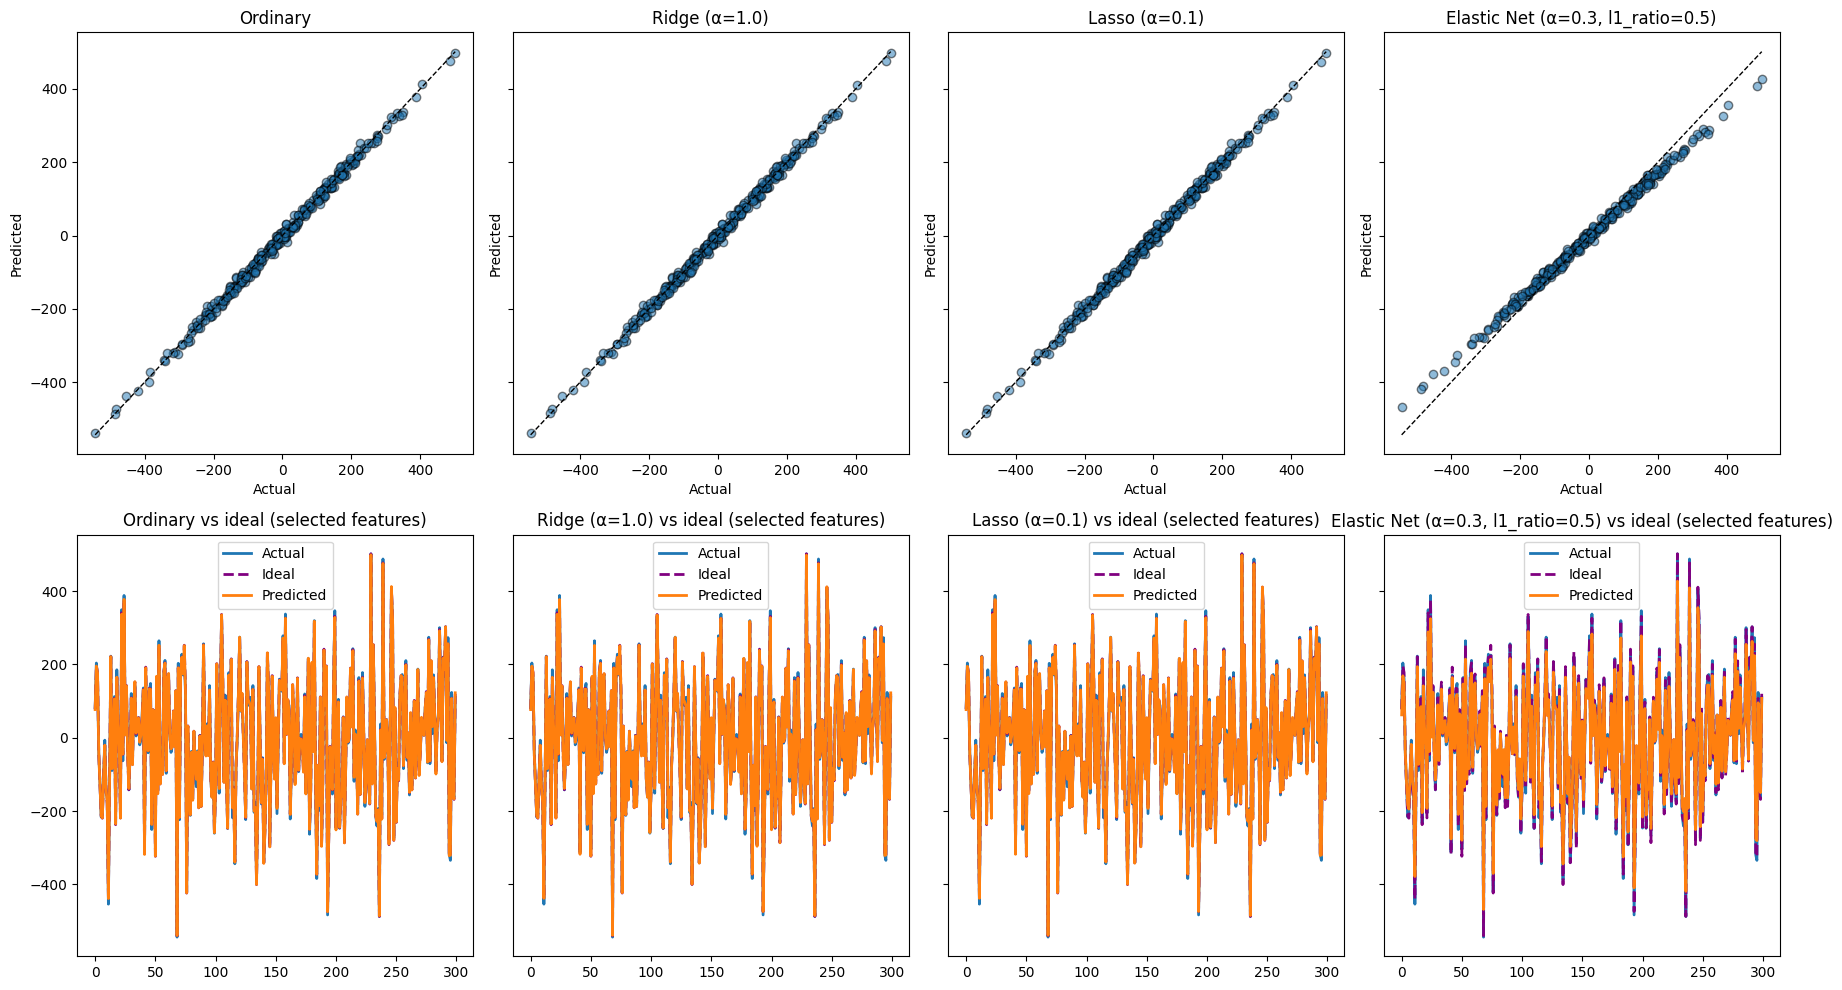

In [29]:
fig, axes = plt.subplots(2, len(predictions_sel), figsize=(18, 10), sharey=True)
axes = axes.reshape(2, -1)
for col, (label, preds) in enumerate(predictions_sel.items()):
    axes[0, col].scatter(y_test_sel, preds, alpha=0.5, edgecolor="k")
    axes[0, col].plot(
        [y_test_sel.min(), y_test_sel.max()],
        [y_test_sel.min(), y_test_sel.max()],
        "k--",
        linewidth=1,
    )
    axes[0, col].set_title(label)
    axes[0, col].set_xlabel("Actual")
    axes[0, col].set_ylabel("Predicted")
    axes[1, col].plot(y_test_sel, label="Actual", linewidth=2)
    axes[1, col].plot(y_ideal_test_sel, "--", label="Ideal", linewidth=2, color="purple")
    axes[1, col].plot(preds, label="Predicted", linewidth=2)
    axes[1, col].set_title(f"{label} vs ideal (selected features)")
    axes[1, col].legend()
plt.tight_layout()
plt.show()

> ✅ After pruning, every model tracks the diagonal—evidence that the feature selection step, not the specific penalty, delivered most of the performance gain.

## Step 6 — Takeaways and next experiments

- Outliers wreak havoc on unregularised models; L1 penalties (Lasso, Elastic Net) dampen their influence best.

- In high dimensions, regularization is more about **feature selection** than pure bias control.

- Elastic Net strikes a nice balance when you expect correlated predictors—it kept pace with Lasso throughout.

- Once you identify the strong features, even plain linear regression shines.



### Where to explore next

- Sweep through different `alpha` values to build stability plots for each estimator.

- Swap synthetic data for a real-world dataset (e.g., housing, finance) and compare behaviours.

- Try cross-validation (`sklearn.model_selection.GridSearchCV`) to automate hyperparameter tuning.



Keep this notebook as a blueprint for designing controlled regularization experiments.